[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/joaoparracho/PyTorch-Workshop/blob/main/classification/cifar10_tutorial.ipynb)

In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

Training a Classifier
=====================

----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a `torch.Tensor`.

-   For images, packages such as Pillow, OpenCV are useful
-   For audio, packages such as scipy and librosa
-   For text, either raw Python or Cython based loading, or NLTK and
    SpaCy are useful

`torchvision` has data loaders for common datasets such as ImageNet, CIFAR10,
MNIST, etc. and data transformers for images, viz.,
`torchvision.datasets` and `torch.utils.data.DataLoader`.

For this tutorial, we will use the CIFAR10 dataset. It has the classes:
'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
'ship', 'truck'. The images in CIFAR-10 are of size 3x32x32, i.e.
3-channel color images of 32x32 pixels in size.

![cifar10](https://pytorch.org/tutorials/_static/img/cifar10.png)

Training an image classifier
----------------------------

We will do the following steps in order:

1.  Load and normalize the CIFAR10 training and test datasets using
    `torchvision`
2.  Define a Convolutional Neural Network
3.  Define a loss function
4.  Train the network on the training data
5.  Test the network on the test data

### 1. Load and normalize CIFAR10



In [2]:
import torch
import torchvision

In [35]:
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from torchvision import datasets
import numpy as np

class Custom_Dataset(Dataset):
    def __init__(self,split="train"):
        is_train = True if split == "train" or split == "val" else False

        transform = transforms.ToTensor()
        self.dataset = datasets.CIFAR10('data', train=is_train, 
                                                download=True,
                                                transform=transform)
                                                
        self.indices = np.arange(0,len(self.dataset))
        print(self.indices)
        # lets use 20% of the trainning dataset to validation
        if split == "train":
            self.indices = self.indices[0:int(len(self.dataset)*0.8)]
        elif split == "val":
            self.indices = self.indices[int(len(self.dataset)*0.8):]
    
    def __getitem__(self, idx):
            image = self.dataset[self.indices[idx]][0]
            label = self.dataset[self.indices[idx]][1]
            return image, label
        
    def __len__(self):
        return len(self.indices)


class Custom_Dataset_Balanced_Split(Dataset):
    def __init__(self,split="train"):
        is_train = True if split == "train" or split == "val" else False
            
        transform = transforms.ToTensor()
        self.dataset = datasets.CIFAR10('data', train=is_train, download=True, transform=transform)
        
        x = np.array(self.dataset.targets)
        sorted_indices = np.argsort(x)
        num_elem_class = int(np.sum(x==0))
        s = np.zeros((10,num_elem_class),int)
        for i in range(10):
            s[i] = sorted_indices[i*num_elem_class:(i+1)*num_elem_class]

        self.sorted_indices = [item for indices in zip(s[0], s[1], s[2],s[3],s[4], s[5],s[6],s[7],s[8],s[9]) for item in indices]
        
        # lets use 20% of the trainning dataset to validation
        if split == "train":
            self.sorted_indices = self.sorted_indices[0:int(len(self.sorted_indices)*0.8)]
        elif split == "val":
            self.sorted_indices = self.sorted_indices[int(len(self.sorted_indices)*0.8):]

    def __getitem__(self, idx):
        image = self.dataset[self.sorted_indices[idx]][0]
        label = self.dataset[self.sorted_indices[idx]][1]
        return image, label
    
    def __len__(self):
        return len(self.sorted_indices)


In [36]:
batch_size = 4   
trainset = Custom_Dataset(split="train")
valset = Custom_Dataset(split="val")
testset = Custom_Dataset(split="test")

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=2)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
[    0     1     2 ... 49997 49998 49999]
Files already downloaded and verified
[    0     1     2 ... 49997 49998 49999]
Files already downloaded and verified
[   0    1    2 ... 9997 9998 9999]


Plot some of the training images


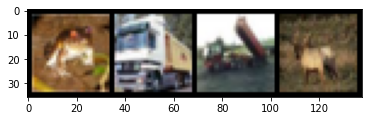

frog  truck truck deer 


In [37]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define the Classifiction model






In [44]:
import torch.nn as nn
import torch.nn.functional as F


class ResidualBlock(nn.Module):
    """Simple residual block with two 3x3 convolutions.

    Args:
        in_ch (int): number of input channels
        out_ch (int): number of output channels
    """

    def __init__(self, in_ch, kernel_size):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, in_ch,kernel_size)
        self.conv2 =  nn.Conv2d(in_ch, in_ch,kernel_size)
        self.conv3 =  nn.Conv2d(in_ch, in_ch,kernel_size)
        self.relu = nn.ReLU()
        self.padding = nn.ReflectionPad2d(2)


    def forward(self, x):
        identity = x

        out = self.conv1(self.padding(x))
        out = self.relu(out)
        out = self.conv2(self.padding(out))
        out = self.relu(out)

        out = out + identity
        return out

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class Net_2(Net):
    def __init__(self):
        super(Net_2, self).__init__()
        self.fc3 = nn.Linear(84, 42)
        self.fc4 = nn.Linear(42, 10)

    def forward(self, x):
        x = self.pool((F.relu(self.conv1(x))))
        x = self.pool((F.relu(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class Net_residual(Net):
    def __init__(self):
        super(Net_residual, self).__init__()
        self.res1 = ResidualBlock(6,5)
        self.res2 = ResidualBlock(16,5)

    def forward(self, x):
        x = self.pool(self.res1(F.relu(self.conv1(x))))
        x = self.pool(self.res2(F.relu(self.conv2(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


### 3. Define a Loss function and optimizer


Let\'s use a Classification Cross-Entropy loss and the Adam optimiser.


In [45]:
import torch.optim as optim
import random
import numpy as np

seed = 0

device = "cuda" if torch.cuda.is_available() else "cpu"
net = Net()
net.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)

accuracy_val_max = 0
checkpoint_path = 'cifar_net.pth'

Let's define a function to compute the model accuracy

In [46]:
def accuracy(x,labels_x):
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(x.data, 1)
    correct = (predicted == labels_x).sum().item()
    return correct

### 4. Train the network


Now it's fun time


In [47]:

print(net)
print(device)
num_epochs = 4

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total += labels.size(0)
        
        correct += accuracy(outputs,labels)
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch }, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            
    print(f'Accuracy of the network on training set: {100 * correct / total} %')
    
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in valloader:
            
            images, labels = data
            images=images.to(device)
            labels=labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            
            total += labels.size(0)
            correct += accuracy(outputs,labels)
            # correct += accuracy(outputs,labels)
    
    accuracy_val = correct / total
    
    if accuracy_val > accuracy_val_max:
        accuracy_val_max = accuracy_val
        torch.save(net.state_dict(), checkpoint_path)
        best_epoch = epoch
            
    print(f'Accuracy of the network on validation set: {np.round(100 * accuracy_val,3)} %')

print("Best epoch: "+str(epoch))
print('Finished Training')

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
cuda
[0,  2000] loss: 2.055
[0,  4000] loss: 1.775
[0,  6000] loss: 1.649
[0,  8000] loss: 1.592
[0, 10000] loss: 1.593
Accuracy of the network on training set: 35.7475 %
Accuracy of the network on validation set: 44.02 %
[1,  2000] loss: 1.529
[1,  4000] loss: 1.530
[1,  6000] loss: 1.479
[1,  8000] loss: 1.446
[1, 10000] loss: 1.465
Accuracy of the network on training set: 46.16 %
Accuracy of the network on validation set: 46.92 %
Best epoch: 1
Finished Training


See [here](https://pytorch.org/docs/stable/notes/serialization.html) for
more details on saving PyTorch models.

### 5. Inference on the test data


Check if the network has learnt anything at all.

This is checked by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Let us, first, display an image from the test set to get
familiar.


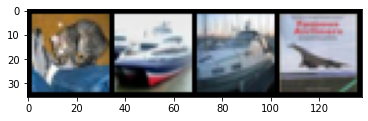

GroundTruth:  cat   ship  ship  plane


In [48]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Load the saved model (note: saving and re-loading
the model wasn\'t necessary here, it's only to illustrate how to do so):


In [49]:
device = "cuda" if torch.cuda.is_available() else "cpu"

net = Net()
net.to(device)
print(checkpoint_path)
net.load_state_dict(torch.load(checkpoint_path))
print(net)

cifar_net.pth
Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


The outputs of the model are energies for the 10 classes. 

The higher the energy for a class, the more the network thinks that the image is of the particular
class. 

Let us look at how the network performs on the whole dataset.


In [50]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images=images.to(device)
        labels=labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 46 %


Performance per class:


In [51]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images=images.to(device)
        labels=labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 53.2 %
Accuracy for class: car   is 67.0 %
Accuracy for class: bird  is 45.0 %
Accuracy for class: cat   is 33.7 %
Accuracy for class: deer  is 34.4 %
Accuracy for class: dog   is 37.4 %
Accuracy for class: frog  is 65.1 %
Accuracy for class: horse is 41.7 %
Accuracy for class: ship  is 33.7 %
Accuracy for class: truck is 56.2 %


So what next?

Now, try to improve the classification performance of the model


**Tips** : 

-   Try to use more epochs
-   Increase the complexity of your network by adding more channels to the convolutional layers.
-   Explore different learning rates. (Change lr argument in the Adam optimiser)
-   Try different models (e.g Net_2(), Net_residual())
-   Try different pre-processing techiques (e.g flipping)

**Goals achieved**:

-   Understanding PyTorch\'s Tensor library and neural networks at a
    high level.
-   Train a small neural network to classify images


In [ ]:
del dataiter